In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

from utils import pattern_utils

In [2]:
n_cpus = 3

# Modern Hopfield Network

This model is a generalization of the original Hopfield network and first appeared in an article by ... and Hofield in 2016 [1].


In [3]:
class modern_hopfield():
  
  def __init__(self, pattern_lenght: int, func_type: str = "Polyn", poly_order: int = 3):
    """
    `pattern_lenght`: number of neurons of the network \n
    `func_type`: type of function to evaluate the energy of a single pattern. 
    Possible options are "Polyn", "RePn", "Exp" \n
    `poly_order`: order of the polynomial function used in the evaluation of the energy
    """
    self.pattern_lenght = pattern_lenght
    self.memory_matrix = np.zeros(shape=(1,self.pattern_lenght))
    self.func_type = func_type
    self.n = poly_order
    return
  
  def add_patterns(self, p: np.ndarray):
    """
    `p`: pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.hstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    `p`: input pattern  \n
    `epochs`: maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def _update_rule(self, sigma: np.ndarray):
    """
    `sigma`: vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)

  def _F(self, x: np.ndarray):
    """
    Energy function used in the update rule. \n
    Different types of function:
    - `Polyn`: polynomial function of order n
    - `RePn`: rectified polynomial function of order n
    - `Exp`: exponential function
    """
    match self.func_type:
      case "Polyn":
        return x**self.n
      case "RePn":
        return np.maximum(0, x**self.n)
      case "Exp":
        return np.exp(x)

# Testing

## Number of maximum patterns retrievable

In this section we want to test how many patterns can a modern hopfield model retrieve without error

In [4]:
# hyperparameters of the analysis
pattern_lenght = 50
n_patterns = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
epochs = 100
max_order = 5

In [5]:
expected_maximum = []
for d in range(2, max_order+1):
  expected_maximum.append(pattern_utils.maximum_recall(pattern_lenght, d))
# expected_maximum.append(2**(pattern_lenght/2))
expected_maximum = np.array(expected_maximum)

In [6]:
results = []
for d in range(2, max_order+1):
  accuracies = []
  for n in n_patterns:
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n)
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type="RePn", poly_order=d)
    model.add_patterns(patterns)

    perm = np.random.randint(0, n, n_patterns[0])
    test = patterns[perm, :]
    acc = 0
    for i, p in enumerate(test):
      r = model.retrieve_pattern(p=p, epochs=epochs)
      if np.array_equal(test[i,:], r):
        acc += 1
    acc /= n_patterns[0] 
    accuracies.append(acc)
  results.append(accuracies)

results = np.array(results)
n_patterns = np.array(n_patterns)

print(results)

[[0.3 0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  0.7 0.1 0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  0.7 0. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


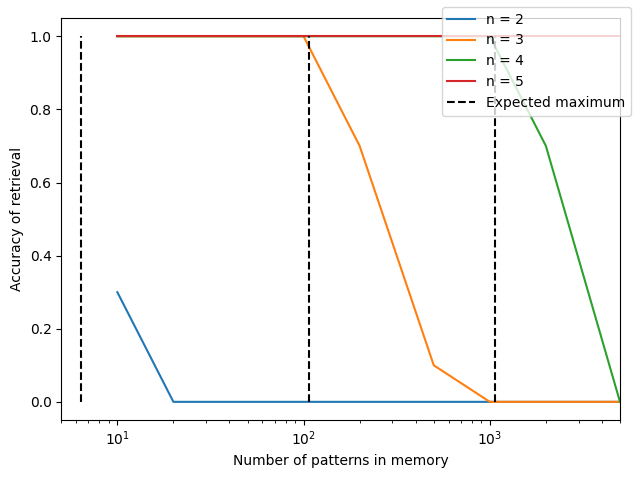

In [7]:
fig, ax = plt.subplots()

for d in range(max_order - 1):
  ax.plot(n_patterns, results[d,:], label=f"n = {d+2}")


ax.vlines(expected_maximum, ymin=0, ymax=1, label="Expected maximum", linestyles="--", color='black')

ax.set_xscale('log')
ax.set_xlim(5, n_patterns[-1])

ax.set_xlabel("Number of patterns in memory")
ax.set_ylabel("Accuracy of retrieval")

fig.legend()

fig.tight_layout()

We can see how the number of patterns retrievable scales somewhat exponentially with the degree $n$ of the polynomial used as the energy function. As $n \to \infty$ we can approximate our polynomial with an exponential function, gaining maximum retrieval capacity $N_{ret}^{max} \sim 2^{L/2}$.

## Corruption
In this section we want to test the ability of our model to retrieve patterns with increasing corruption applied to them.

In [7]:
# hyperparameters of the analysis
steps = 11
poly_order = 5
pattern_lenght = 100
n_patterns = 200
n_trials = 10
n_test = 20
epochs = 100

In [8]:
def corruption_analysis(func_type: str):
  """
  `func_type`: function type to initialize the model \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  accuracies = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_order=poly_order)
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # testing over the range of corruptions
    corruption_quantity = np.linspace(0, 1, steps)
    correctly_identified = []
    for q in corruption_quantity:
      # selecting randomly n_test patterns to corrupt
      test_idx = np.random.randint(0, n_patterns, n_test, )
      corrupted = pattern_utils.corrupt_patterns(patterns=patterns[test_idx,:], q=q, corruption_type="Flip")
      
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(r, patterns[test_idx[i],:]): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracies.append(np.array(correctly_identified) / n_test)
  return np.array(accuracies)

In [9]:
func_type = ["Polyn", "RePn", "Exp"]
pool = Pool(n_cpus)
results = pool.map(corruption_analysis, func_type)

In [10]:
print(np.std(results[0], axis=0))

[0.         0.         0.015      0.08124038 0.08674676 0.015
 0.09165151 0.04582576 0.015      0.         0.        ]


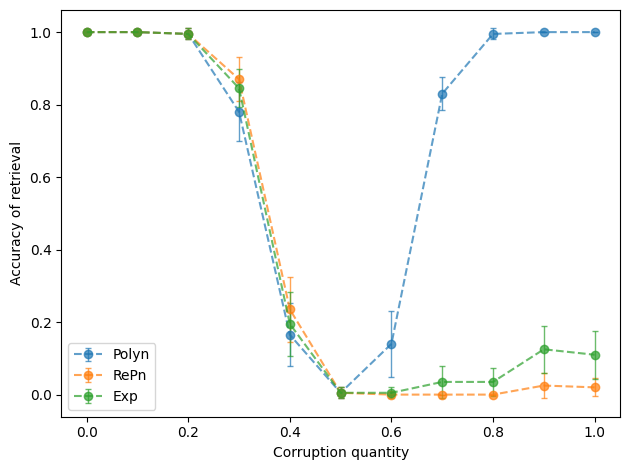

In [12]:
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=func_type[i],
              fmt='o--', capsize=2, alpha=0.7, elinewidth=1)

ax.set_xlabel("Corruption quantity")
ax.set_ylabel("Accuracy of retrieval")

ax.legend(loc='lower left')
fig.tight_layout()